In [1]:
 !nvidia-smi

Tue Jun  8 11:19:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!free -th

              total        used        free      shared  buff/cache   available
Mem:            12G        611M        8.7G        1.1M        3.4G         11G
Swap:            0B          0B          0B
Total:          12G        611M        8.7G


In [3]:
import numpy as np
from sklearn import model_selection
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import re
import string
import random

Load dataset

In [4]:
DATASET_PATH = 'drive/MyDrive/svg/order_svg_dataset_1000k.csv'

def transform_data(data):
  def wrap_separators(text):
    separators = [r'=', r'"', r',', r'\)', r'rgb\(', r'/>']
    replace = [r'=', r'"', r',', r')', r'rgb(', r'/>']
    for sep, rep in zip(separators, replace):
      text = re.sub(sep, f' {rep} ', text)
    
    return text

  return np.array([re.sub(' +', ' ', f'# {wrap_separators(x)} $ {wrap_separators(y)} %') for x, y in zip(data['x'], data['y'])])

data_train, data_validation = model_selection.train_test_split(pd.read_csv(DATASET_PATH, header=0, usecols=['x', 'y']), test_size=.05)

In [5]:
batch_size = 16

train_text_ds = tf.data.Dataset.from_tensor_slices(transform_data(data_train)).batch(batch_size)
validation_text_ds = tf.data.Dataset.from_tensor_slices(transform_data(data_validation)).batch(batch_size)

Load model and vectorizer

In [6]:
import pickle
from tensorflow.keras.layers.experimental import preprocessing

MAX_SEQUENCE_LENGTH = 300   # Max sequence size
EMBEDDING_DIM = 50          # Embedding size for each token
NUM_ATTENTION_HEADS = 12    # Number of attention heads
FEED_FORWARD_DIM = 256      # Hidden layer size in feed forward network inside transformer
NUM_TRANSFORMER_BLOCKS = 5  # Number of transformer blocks

def load_text_vectorization(path):
    from_disk = pickle.load(open(path, 'rb'))
    vectorize_layer = preprocessing.TextVectorization.from_config(from_disk['config'])
    vectorize_layer.set_weights(from_disk['weights'])

    return vectorize_layer

vectorize_layer = load_text_vectorization('drive/MyDrive/svg/vectorize_layer_0_08-06_09-05')
vocabulary = vectorize_layer.get_vocabulary()

model = keras.models.load_model('drive/MyDrive/svg/model_1_08-06_10-55')

Vectorizer

In [7]:
# MAX_SEQUENCE_LENGTH = 300   # Max sequence size
# EMBEDDING_DIM = 50          # Embedding size for each token
# NUM_ATTENTION_HEADS = 12    # Number of attention heads
# FEED_FORWARD_DIM = 256      # Hidden layer size in feed forward network inside transformer
# NUM_TRANSFORMER_BLOCKS = 5  # Number of transformer blocks

# vectorize_layer = layers.experimental.preprocessing.TextVectorization(
#     standardize=tf.strings.lower,
#     output_mode='int',
#     output_sequence_length=MAX_SEQUENCE_LENGTH + 1)

# vectorize_layer.adapt(train_text_ds)
# vocabulary = vectorize_layer.get_vocabulary() # To get words back from token indices
# VOCABULARY_SIZE = len(vocabulary)

Transformer

In [8]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TransformerBlock(layers.Layer):
    def __init__(self, embedding_dim, num_attention_heads, ff_dim, rate=.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_attention_heads, embedding_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embedding_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_sequence_len, vocabulary_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)
        self.pos_emb = layers.Embedding(input_dim=max_sequence_len, output_dim=embedding_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
def create_model():
    inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    embedding_layer = TokenAndPositionEmbedding(MAX_SEQUENCE_LENGTH, VOCABULARY_SIZE, EMBEDDING_DIM)
    x = embedding_layer(inputs)
    for n in range(NUM_TRANSFORMER_BLOCKS):
      transformer_block = TransformerBlock(EMBEDDING_DIM, NUM_ATTENTION_HEADS, FEED_FORWARD_DIM)
      x = transformer_block(x)
    outputs = layers.Dense(VOCABULARY_SIZE)(x)

    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    model.compile(keras.optimizers.Adam(learning_rate=1e-4),
                  loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), None]) # No loss and optimization based on word embeddings from transformer block
    return model

def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

Instantiate the model

In [10]:
# model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
token_and_position_embedding (None, 300, 50)           41450     
_________________________________________________________________
transformer_block (Transform (None, 300, 50)           147956    
_________________________________________________________________
transformer_block_1 (Transfo (None, 300, 50)           147956    
_________________________________________________________________
transformer_block_2 (Transfo (None, 300, 50)           147956    
_________________________________________________________________
transformer_block_3 (Transfo (None, 300, 50)           147956    
_________________________________________________________________
transformer_block_4 (Transfo (None, 300, 50)           147956

Instantiate the text generator

In [11]:
import svg_generator

text_generator = svg_generator.TextGenerator(model, vocabulary, MAX_SEQUENCE_LENGTH)

Map data

In [12]:
def convert_data(text_ds):
  return text_ds.map(prepare_lm_inputs_labels).cache().prefetch(tf.data.experimental.AUTOTUNE)

train_data, validation_data = convert_data(train_text_ds), convert_data(validation_text_ds)

Visualise examples

In [13]:
class CustomEpochEndCallback(keras.callbacks.Callback):
  def __init__(self, print_every, callback_function):
    self.print_every = print_every
    self.callback_function = callback_function

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.print_every != 0:
      return

    self.callback_function(epoch)

"""
Generate and visualise from initial prompts
"""
def text_prompts(start_prompts):
  for initial_promp in start_prompts:
    text_generator.generate(initial_promp)

"""
Generate and visualise n entries from the dataset
"""
def sample_from_dataset(n=50):
  for x, y in data_validation.head(n).values:
    text_generator.generate(x)
    print('Actual above\n')
    text_generator.display_code(y)
    print('Expected above\n')

"""
Save the vectorizer and the model
"""
def save_transformer(folder_path, epoch):
  import datetime
  import pickle
  def save_vectorizer(path):
    pickle.dump({'config': vectorize_layer.get_config(),
                'weights': vectorize_layer.get_weights()},
                open(path, 'wb'))
  
  today = datetime.datetime.today()
  date = today.strftime('%d-%m')
  time = today.strftime('%H-%M')

  save_vectorizer(f'{folder_path}/vectorize_layer_{epoch}_{date}_{time}')
  model.save(f'{folder_path}/model_{epoch}_{date}_{time}')

callbacks = [
  tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/svg/checkpoint', mode='min', save_best_only=True, monitor='loss', save_freq=5000),
  CustomEpochEndCallback(1, lambda epoch: save_transformer('drive/MyDrive/svg/', epoch)),
  CustomEpochEndCallback(1, lambda epoch: text_prompts(['small red rectangle in bottom left and cyan average circle behind', 'purple large circle in center and green medium circle in front and blue tiny circle in front green medium circle', 'green small rectangle in center and blue tiny circle above and red tiny circle below green small rectangle', 'tiny red rectangle in left, small green rectangle to right, medium blue rectangle to right small green rectangle'])),
  CustomEpochEndCallback(2, lambda epoch: sample_from_dataset())
]

Epoch 3/5
 5000/59375 [=>............................] - ETA: 1:18:48 - loss: 0.2436 - dense_10_loss: 0.2436

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


15000/59375 [======>.......................] - ETA: 1:04:47 - loss: 0.2435 - dense_10_loss: 0.2435

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


20000/59375 [=========>....................] - ETA: 57:40 - loss: 0.2434 - dense_10_loss: 0.2434

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


25000/59375 [===========>..................] - ETA: 50:24 - loss: 0.2434 - dense_10_loss: 0.2434

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


30000/59375 [==============>...............] - ETA: 43:12 - loss: 0.2433 - dense_10_loss: 0.2433

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


35000/59375 [================>.............] - ETA: 35:53 - loss: 0.2431 - dense_10_loss: 0.2431

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


40000/59375 [===================>..........] - ETA: 28:34 - loss: 0.2430 - dense_10_loss: 0.2430

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


45000/59375 [=====================>........] - ETA: 21:14 - loss: 0.2429 - dense_10_loss: 0.2429

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


50000/59375 [========================>.....] - ETA: 13:51 - loss: 0.2429 - dense_10_loss: 0.2429

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


55000/59375 [==========================>...] - ETA: 6:28 - loss: 0.2428 - dense_10_loss: 0.2428

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


59375/59375 [==============================] - 5403s 91ms/step - loss: 0.2427 - dense_10_loss: 0.2427 - val_loss: 0.2402 - val_dense_10_loss: 0.2402


INFO:tensorflow:Assets written to: drive/MyDrive/svg//model_2_08-06_12-52/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg//model_2_08-06_12-52/assets


Generated text:
# small red rectangle in bottom left and cyan average circle behind $ <circle cx = " 40 " cy = " -24 " r = " 29 " fill = " rgb( 0 , 255 , 255 ) " stroke-width = " -1 " /> <rect x = " 30 " y = " -33 " width = " 20 " height = " 17 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> % <circle cx = " 40 " cy = " -24 " r = " 29 " fill = " rgb( 0 , 255 , 255 ) " stroke-width = " -1 " /> <rect x = " 30 " y = " -33 " width = " 20 " height = " 17 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> %

Code:  <circle cx = " 40 " cy = " -24 " r = " 29 " fill = " rgb( 0 , 255 , 255)" stroke-width = " -1 " /> <rect x = " 30 " y = " -33 " width = " 20 " height = " 17 " fill = " rgb( 255 , 0 , 0)" stroke-width = " 0 " />


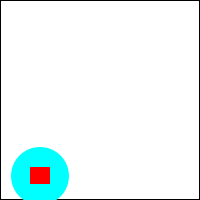

Generated text:
# purple large circle in center and green medium circle in front and blue tiny circle in front green medium circle $ <circle cx = " 94 " cy = " -107 " r = " 4 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 2 " /> <circle cx = " 94 " cy = " -107 " r = " 29 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 1 " /> <circle cx = " 94 " cy = " -107 " r = " 51 " fill = " rgb( 113 , 0 , 132 ) " stroke-width = " 0 " /> % <circle cx = " 94 " cy = " -107 " r = " 4 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 2 " /> <circle cx = " 94 " cy = " -107 " r = " 29 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 1 " /> <circle cx = " 94 " cy = " -107 " r = " 51 " fill = " rgb( 113 , 0 , 132 ) " stroke-width = " 0 " /> %

Code:  <circle cx = " 94 " cy = " -107 " r = " 4 " fill = " rgb( 0 , 0 , 255)" stroke-width = " 2 " /> <circle cx = " 94 " cy = " -107 " r = " 29 " fill = " rgb( 0 , 255 , 0)" stroke-width = " 1 " /> <circle cx = " 94 " cy = " -107 " r = " 51 " fill = " rgb( 113 , 0

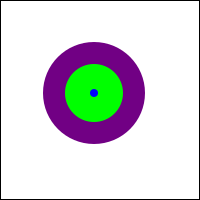

Generated text:
# green small rectangle in center and blue tiny circle above and red tiny circle below green small rectangle $ <circle cx = " 96 " cy = " -38 " r = " 4 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> <circle cx = " 96 " cy = " -176 " r = " 4 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 0 " /> <rect x = " 91 " y = " -107 " width = " 20 " height = " 20 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 0 " /> % <circle cx = " 96 " cy = " -38 " r = " 4 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> <circle cx = " 96 " cy = " -176 " r = " 4 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 0 " /> <rect x = " 91 " y = " -107 " width = " 20 " height = " 20 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 0 " /> %

Code:  <circle cx = " 96 " cy = " -38 " r = " 4 " fill = " rgb( 255 , 0 , 0)" stroke-width = " 0 " /> <circle cx = " 96 " cy = " -176 " r = " 4 " fill = " rgb( 0 , 0 , 255)" stroke-width = " 0 " /> <rect x = " 91 " y = " -107 " width = " 20 " heigh

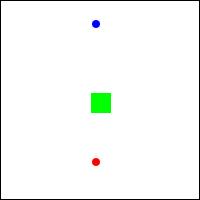

Generated text:
# tiny red rectangle in left , small green rectangle to right , medium blue rectangle to right small green rectangle $ <rect x = " 169 " y = " -125 " width = " 63 " height = " 61 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 0 " /> <rect x = " 89 " y = " -107 " width = " 20 " height = " 20 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 0 " /> <rect x = " 32 " y = " -103 " width = " 10 " height = " 10 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> % <rect x = " 169 " y = " -125 " width = " 63 " height = " 61 " fill = " rgb( 0 , 0 , 255 ) " stroke-width = " 0 " /> <rect x = " 89 " y = " -107 " width = " 20 " height = " 20 " fill = " rgb( 0 , 255 , 0 ) " stroke-width = " 0 " /> <rect x = " 32 " y = " -103 " width = " 10 " height = " 10 " fill = " rgb( 255 , 0 , 0 ) " stroke-width = " 0 " /> %

Code:  <rect x = " 169 " y = " -125 " width = " 63 " height = " 61 " fill = " rgb( 0 , 0 , 255)" stroke-width = " 0 " /> <rect x = " 89 " y = " -107 " width = " 20 " he

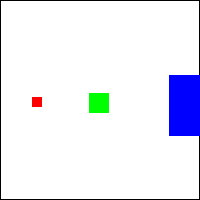

Epoch 4/5
  625/59375 [..............................] - ETA: 1:27:30 - loss: 0.2423 - dense_10_loss: 0.2423

INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


INFO:tensorflow:Assets written to: drive/MyDrive/svg/checkpoint/assets


 5060/59375 [=>............................] - ETA: 1:21:10 - loss: 0.2422 - dense_10_loss: 0.2422

KeyboardInterrupt: ignored

In [15]:
model.fit(train_data, validation_data=validation_data, verbose=1, initial_epoch=2, epochs=5, callbacks=callbacks)